In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import sampler
import tensorflow as tf
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T
import cv2
from google.colab import drive
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

import time, os, json
from skimage import io, transform

import torch.nn.functional as F
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import sys
import os
py_file_location = "/content/drive/My Drive/captcha-solver"
sys.path.append(os.path.abspath(py_file_location))
!cd "/content/drive/My Drive/captcha-solver"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import character_segmenter
from noise_remover import NoiseRemover
from character_segmenter import CharacterSegmenter


In [ ]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [ ]:
X_=[]
y_=[]

num_bad_captchas=0
for dirname, _, filenames in os.walk('/content/drive/MyDrive/captcha-solver/data/moreBetter/captchas'):
    for filename in filenames:
        img_fn = os.path.split(filename)[1] # convert from "data/captchas/1ZX0.jpg" to "1ZX0.jpg"
        captcha_label = img_fn.split(".")[0] # convert from "1ZX0.jpg" to "1ZX0"

        path=os.path.join(dirname, filename)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        _, img = cv2.threshold(img, 230, 255, cv2.THRESH_BINARY)
        # clean up the image by removing noise

        clean_image = NoiseRemover.remove_all_noise(img)

        masks, mask_sizes, mask_start_indices, mask_char_pixels_arrs = CharacterSegmenter.get_components(clean_image)
        if len(masks) == 0:
          num_bad_captchas += 1
          continue

        # segment and extract characters
        masks, mask_start_indices = CharacterSegmenter.segment_characters(masks, mask_sizes, mask_start_indices, mask_char_pixels_arrs)
        if not len(masks) == 4:
            num_bad_captchas += 1
            continue


    # reorder masks and starting indices in ascending order to align them with the proper character for labeling
        mask_start_indices, indices = zip(*sorted(zip(mask_start_indices, [i for i in range(len(mask_start_indices))]))) # make sure intervals are in left-to-right order so we can segment characters properly
        masks = [masks[i] for i in indices]
        char_infos = [(masks[i], captcha_label[i]) for i in range(len(masks))]

    # save characters to disk
        for index, char_info in enumerate(char_infos):
            char_crop, label = char_info

        # reshape character crop to 76x76
            char_crop = CharacterSegmenter.squarify_image(char_crop)
            char_crop = ~char_crop

        # save digit to file so we can train a CNN later
            X_.append(np.array(Image.fromarray(char_crop)).reshape(1,76,76)   )
            y_.append(captcha_label[index])

X_=np.array(X_)
y_=np.array(y_)

L


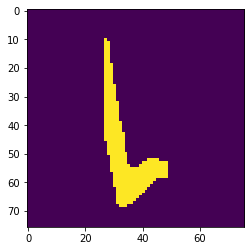

In [ ]:
plt.imshow(X_[1][0], interpolation='nearest')
print(y_[1])

In [ ]:

#creating my vocabluary
zipped_words = {}

words= np.array(["1","2","3","4","5","6","7","8","9","0","A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"])
print(y_.shape)
print(X_.shape)
arr = np.zeros((X_.shape[0]))

for idx,w in enumerate(words):
    zipped_words[w]= idx

for idx,y__ in enumerate(y_):
    arr[idx]=np.array((np.where(words == y__)[0][0] ))

y= arr.astype(int)
print(((words.shape)))


(31876,)
(31876, 1, 76, 76)
(36,)


In [ ]:
print(y)
print(X_[0].shape)

[25 21 10 ... 32 27  9]
(1, 76, 76)


In [ ]:

class MyDataset(Dataset):
    def __init__(self, label, img):
        self.label = label
        self.img = img

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        label = self.label[idx]
        data = self.img[idx]
        sample = (data, label)
        return sample


In [ ]:
my_dataset_train = MyDataset(label= y[0:30000],img=X_[0:30000])

In [ ]:
my_dataset_val= MyDataset(label= y[30000:],img=X_[30000:])

P


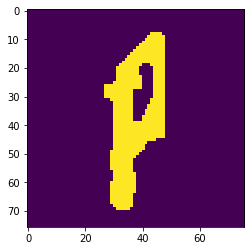

L


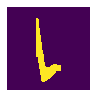

A


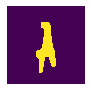

7


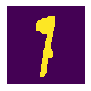

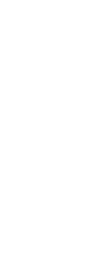

In [ ]:
for i in range(len(my_dataset_train)):
    img ,y  = my_dataset_train[i]
    print(words[y])
    plt.imshow(img[0], interpolation='nearest')
    plt.show()
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.axis('off')
    if i == 3:
        break

In [ ]:
loader_train = DataLoader(my_dataset_train, batch_size=128,
                          shuffle = True)

In [ ]:
loader_val = DataLoader(my_dataset_val, batch_size=1,
                          shuffle = False)

In [ ]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ')
    print(x)
    print('\nAfter flattening: ')
    print(flatten(x))

# wrap `flatten` function in a module in order to stack it
# in nn.Sequential

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [ ]:
def train_part34(model, optimizer, epochs=1):

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        total = 0
        accur = 0
        for t, (x, y) in enumerate(loader_train): # enumerate data loader into my model
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            for idx,scr in enumerate(scores):
               total+=1
               s= torch.argmax(scr).item()
               if s == y[idx]:
                accur+=1
            loss = F.cross_entropy(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % print_every == 0:
                if t==0:
                  print("---------Epoch: ",e,"-------------")
                print('Iteration %d, loss = %.4f' % (e, loss.item()))

        print("Epoch Number: ",e,"Accuracy of the model : ",(accur)/total)
        val(model,words)



In [ ]:
def val(model,words):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    accur= 0
    total=0
    captch=[]
    actual=[]
    c=0
    for t, (x, y) in enumerate(loader_val): # enumerate data loader into my model
        x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.long)
        scores = model(x)
        s=  torch.argmax(scores).item()
        total+=1
        if s == y:
          accur+=1
        """        actual.append(words[y])
        captch.append(words[s])
        c=c+1
        if c==4:
          total+=1
          if captch == actual:
            accur+=1
          captch=[]
          actual=[]
          c=0"""

    print("Accuracy on Validation",accur/total)


In [ ]:
def val_predict(model,words,loader):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    accur= 0
    total=0
    captch=[]
    actual=[]
    c=0
    for t, (x, y) in enumerate(loader): # enumerate data loader into my model
        x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.long)
        scores = model(x)
        s=  torch.argmax(scores).item()
        total+=1
        if s == y:
          accur+=1
        actual.append(words[y])
        captch.append(words[s])
        c=c+1
        if c==4:
          print("Actual",actual)
          print("Predicted",captch)
          captch=[]
          actual=[]
          c=0

    print("Accuracy on the given Directory",accur/total)
    print("Total number of characters:", total)
    print("Total number of characters correctly predicted:", accur)

Architecture:

  2 Conv Layer

  2 Maximum Pooling Layer

  2 Fully Connected Layer




For Optimization: We used ADAMS instead of SGD and chose cross entropy loss for loss function

In [ ]:
cnn_model = None
cnn_optimizer = None

learning_rate = 1e-4

cnn_model = nn.Sequential(


            nn.Conv2d(in_channels = 1, out_channels = 20, kernel_size = (5, 5), stride = (1, 1), padding = (4, 4)),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False),
            nn.Conv2d(in_channels = 20, out_channels = 50, kernel_size = (5, 5), stride = (1, 1), padding = (4, 4)),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False),
            nn.Flatten(),
            nn.Linear(in_features = 24200, out_features = 500, bias = True),
            nn.ReLU(inplace = True),
            nn.Linear(in_features = 500, out_features = 36, bias = True)

         )

# Adams optimizer
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)
pass


train_part34(cnn_model, cnn_optimizer, epochs=23)


---------Epoch:  0 -------------
Iteration 0, loss = 6.9486


In [ ]:
val(cnn_model,words)

Accuracy on Validation 0.8448827292110874


In [ ]:
def predict(directory,model):
  characters_to_predict=[]
  y_predict=[]
  for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
        img_fn = os.path.split(filename)[1] # convert from "data/captchas/1ZX0.jpg" to "1ZX0.jpg"
        captcha_label = img_fn.split(".")[0] # convert from "1ZX0.jpg" to "1ZX0"

        path=os.path.join(dirname, filename)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        _, img = cv2.threshold(img, 230, 255, cv2.THRESH_BINARY)
        # clean up the image by removing noise

        clean_image = NoiseRemover.remove_all_noise(img)

        masks, mask_sizes, mask_start_indices, mask_char_pixels_arrs = CharacterSegmenter.get_components(clean_image)
        if len(masks) == 0:
          print("captcha_couldn't pass")
          continue

        # segment and extract characters
        masks, mask_start_indices = CharacterSegmenter.segment_characters(masks, mask_sizes, mask_start_indices, mask_char_pixels_arrs)
        if not len(masks) == 4:
            print("captcha_couldn't pass")
            continue


    # reorder masks and starting indices in ascending order to align them with the proper character for labeling
        mask_start_indices, indices = zip(*sorted(zip(mask_start_indices, [i for i in range(len(mask_start_indices))]))) # make sure intervals are in left-to-right order so we can segment characters properly
        masks = [masks[i] for i in indices]
        char_infos = [(masks[i], captcha_label[i]) for i in range(len(masks))]

    # save characters to disk
        for index, char_info in enumerate(char_infos):
            char_crop, label = char_info

        # reshape character crop to 76x76
            char_crop = CharacterSegmenter.squarify_image(char_crop)
            char_crop = ~char_crop

        # save digit to file so we can train a CNN later
            characters_to_predict.append(np.array(Image.fromarray(char_crop)).reshape(1,76,76)   )
            y_predict.append(captcha_label[index])
    arr = np.zeros(len(characters_to_predict))
    for idx,y__ in enumerate(y_predict):
        arr[idx]=np.array((np.where(words == y__)[0][0] ))
    y_predict= arr.astype(int)
    characters_to_predict=np.array(characters_to_predict)
    y_predict=np.array(y_predict)

    my_dataset_predict = MyDataset(label= y_predict,img=characters_to_predict)
    loader_predict = DataLoader(my_dataset_predict, batch_size=1,
                          shuffle = False)
    val_predict(model,words,loader_predict)





In [ ]:
#Accurcy on the test Dataset
predict('/content/drive/MyDrive/captcha-solver/data/captchas',cnn_model)

Actual ['0', 'J', 'K', 'T']
Predicted ['0', 'J', 'K', 'T']
Actual ['7', 'H', 'Y', 'Q']
Predicted ['7', 'H', 'J', 'Q']
Actual ['F', '6', 'E', '5']
Predicted ['F', '6', 'E', '5']
Actual ['S', 'W', 'I', '1']
Predicted ['S', 'W', 'I', 'S']
Actual ['G', 'D', '5', 'J']
Predicted ['G', 'D', '5', 'L']
Actual ['J', 'L', 'O', 'H']
Predicted ['J', 'L', 'O', 'H']
Actual ['7', 'H', 'P', 'Z']
Predicted ['7', 'H', 'P', 'Z']
Actual ['B', 'G', 'H', '7']
Predicted ['6', 'G', 'H', '7']
Actual ['A', '6', 'V', 'Y']
Predicted ['A', '6', 'V', 'Y']
Actual ['O', 'C', 'G', '2']
Predicted ['0', 'C', 'G', '2']
Actual ['D', 'Q', 'B', 'L']
Predicted ['D', 'Q', 'B', 'L']
Actual ['Q', 'G', '6', 'S']
Predicted ['Q', 'G', '6', 'S']
Actual ['X', 'J', 'I', 'Y']
Predicted ['X', 'J', 'I', 'Y']
Actual ['S', 'X', 'N', '6']
Predicted ['S', 'X', 'N', '6']
Actual ['V', '2', '4', '9']
Predicted ['V', '2', '4', '9']
Actual ['2', 'G', '3', 'K']
Predicted ['2', 'G', '3', 'K']
Actual ['I', 'N', '8', 'P']
Predicted ['I', 'N', 'V', 'P

In [ ]:
def gaussian(directory,directory_save,mean,sigma):

  for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
      img_fn = os.path.split(filename)[1] # convert from "data/captchas/1ZX0.jpg" to "1ZX0.jpg"
      captcha_label = img_fn.split(".")[0] # convert from "1ZX0.jpg" to "1ZX0"
      path=os.path.join(dirname, filename)
      img = cv2.imread(path, 0)

      gauss_noise=np.zeros((76,140),dtype=np.uint8)
      cv2.randn(gauss_noise,mean,20)
      gauss_noise=(gauss_noise*0.5).astype(np.uint8)
      gn_img=cv2.add(img,gauss_noise)

      cv2.imwrite(os.path.join(directory_save , img_fn), gn_img)
      cv2.waitKey(0)


In [ ]:
 gaussian('/content/drive/MyDrive/captcha-solver/data/gaussian','/content/drive/MyDrive/captcha-solver/data/save_gaus',100,100)

In [ ]:
cd "/content/drive/MyDrive/captcha-solver/data/save_gauss"

[Errno 2] No such file or directory: '/content/drive/MyDrive/captcha-solver/data/save_gauss'
/content


In [ ]:
#burdaki captcha couldnt pass yazısı model tahmin etmekte başarısız olduğu için çıkıyor
#onu da başarısızdan saymamız lazım bu durumda
predict('/content/drive/MyDrive/captcha-solver/data/save_gaus',cnn_model)

captcha_couldn't pass
captcha_couldn't pass
captcha_couldn't pass
captcha_couldn't pass
captcha_couldn't pass
Actual ['7', '5', 'C', 'J']
Predicted ['7', '5', 'C', 'J']
Actual ['N', 'M', '0', 'O']
Predicted ['N', 'M', '5', 'Z']
Actual ['B', 'G', 'H', '7']
Predicted ['5', 'G', 'H', '7']
Actual ['Y', 'X', 'J', 'E']
Predicted ['Y', 'X', 'J', 'E']
Actual ['D', '5', 'O', '9']
Predicted ['Y', 'I', 'I', '3']
Actual ['6', 'E', 'S', 'D']
Predicted ['6', 'E', 'E', 'D']
Actual ['J', 'L', 'O', 'H']
Predicted ['J', 'L', 'O', 'H']
Actual ['L', 'C', 'B', 'N']
Predicted ['L', 'C', 'B', 'N']
Actual ['X', 'H', 'W', '6']
Predicted ['O', 'H', 'H', '6']
Actual ['D', '7', 'M', '5']
Predicted ['D', '7', 'V', '5']
Actual ['C', '9', '8', 'B']
Predicted ['C', '9', 'B', 'B']
Actual ['3', 'N', 'D', 'B']
Predicted ['3', 'N', 'D', 'B']
Actual ['9', '5', 'V', '0']
Predicted ['P', 'X', 'T', 'V']
Actual ['X', 'Z', 'L', 'C']
Predicted ['X', 'Z', 'L', 'C']
Actual ['E', 'V', 'B', 'Y']
Predicted ['E', 'S', 'R', 'Y']
Accur

In [ ]:
predict('/content/drive/MyDrive/captcha-solver/data/gaussian',cnn_model)

Actual ['7', '5', 'C', 'J']
Predicted ['7', '5', 'C', 'J']
Actual ['N', 'M', '0', 'O']
Predicted ['N', 'M', 'O', 'O']
Actual ['B', 'G', 'H', '7']
Predicted ['6', 'G', 'H', '7']
Actual ['Y', 'X', 'J', 'E']
Predicted ['Y', 'X', 'J', 'E']
Actual ['G', '8', 'S', 'E']
Predicted ['G', 'P', '8', '5']
Actual ['1', 'X', 'H', 'J']
Predicted ['7', 'H', '7', 'W']
Actual ['D', '5', 'O', '9']
Predicted ['D', '5', 'O', '9']
Actual ['6', 'E', 'S', 'D']
Predicted ['6', 'E', 'F', 'D']
Actual ['J', 'L', 'O', 'H']
Predicted ['J', 'L', 'O', 'H']
Actual ['9', 'O', 'Q', 'J']
Predicted ['9', 'O', 'Q', 'J']
Actual ['V', 'W', 'I', 'T']
Predicted ['V', '7', 'I', 'T']
Actual ['L', 'C', 'B', 'N']
Predicted ['L', 'C', 'B', 'N']
Actual ['X', 'H', 'W', '6']
Predicted ['X', 'H', 'W', '6']
Actual ['D', '7', 'M', '5']
Predicted ['D', '7', 'M', '5']
Actual ['C', '9', '8', 'B']
Predicted ['C', '9', '8', 'B']
Actual ['3', 'N', 'D', 'B']
Predicted ['3', 'N', 'O', 'B']
Actual ['K', 'Q', 'J', 'G']
Predicted ['F', 'Q', 'J', 'G

In [ ]:
gaussian_means = [0,10,20,30,40,50,60,70,80,90,100,120]
for mean_noise in gaussian_means:
  print("---------------- Doing for mean/noise", mean_noise,"---------------------" )
  path_to_save = '/content/drive/MyDrive/captcha-solver/data/save_gaus'+str(mean_noise)

  gaussian('/content/drive/MyDrive/captcha-solver/data/gaussian',path_to_save,mean_noise,mean_noise)
  predict(path_to_save,cnn_model)


---------------- Doing for mean/noise 0 ---------------------


NameError: ignored

In [ ]:
def salt_pepper_noise(directory,directory_save,noise):
  for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
      img_fn = os.path.split(filename)[1] # convert from "data/captchas/1ZX0.jpg" to "1ZX0.jpg"
      captcha_label = img_fn.split(".")[0] # convert from "1ZX0.jpg" to "1ZX0"
      path=os.path.join(dirname, filename)
      img = cv2.imread(path)
      # Add salt-and-pepper noise to the image.
      noise_img = random_noise(img, mode='s&p',amount=noise)
      noise_img = np.array(255*noise_img, dtype = 'uint8')
      cv2.imwrite(os.path.join(directory_save , img_fn), noise_img)
      cv2.waitKey(0)

In [ ]:
salt_noise = [0.01,0.05,0.1,0.15,0.2,0.3]
for mean_noise in salt_noise:
  print("---------------- Doing for mean/noise", mean_noise,"---------------------" )
  path_to_save = '/content/drive/MyDrive/captcha-solver/data/salt_save'+str(mean_noise)
  salt_pepper_noise('/content/drive/MyDrive/captcha-solver/data/salt',path_to_save,mean_noise)
  predict(path_to_save,cnn_model)

In [ ]:
gaussian_means = [20,50,80,100]
salt_noise = [0.05,0.1,0.2]
for mean_noise in gaussian_means:
  for noise in salt_noise:
    print("---------------- Doing for Gaussian mean/noise", mean_noise," AND for salt noise ",noise," ---------------------" )
    path_to_get'/content/drive/MyDrive/captcha-solver/data/save_gaus'+str(mean_noise)

    path_to_save = '/content/drive/MyDrive/captcha-solver/data/save_gaus_salt_'+str(noise)+str(mean_noise)

    salt_pepper_noise(path_to_get,path_to_save,noise)

    predict(path_to_save,cnn_model)
